In [1]:
# Uncomment the following line to install the required packages

# %pip install langchain openai langchain_openai langchain_core langgraph

In [2]:
import sys
import os

if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    from google.colab import userdata

    # get secret openai_api_key and set it to OS env OPENAI_API_KEY
    try:
      openai_api_key = userdata.get('openai_api_key')
      os.environ['OPENAI_API_KEY'] = openai_api_key
    except:
      print("No openai_api_key found in Google Colab")

    # get secret openai_base_url
    try:
      openai_base_url = userdata.get('openai_base_url')
      os.environ['OPENAI_API_BASE'] = openai_base_url
    except:
      print("No openai_base_url found in Google Colab")
else:
    print("Not running in Google Colab")

Not running in Google Colab


In [3]:
from typing import Annotated, Sequence, Dict, Any

from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel

import operator
import random

# Can converge correctly

# MODEL_NAME = "anthropic/claude-3.5-sonnet:beta"
# MODEL_NAME = "llama3-70b-8192"
# MODEL_NAME = "meta-llama/llama-3-70b-instruct"
MODEL_NAME = "deepseek/deepseek-chat"
# MODEL_NAME = "qwen/qwen-2-72b-instruct"

# Failed to converge correctly

# MODEL_NAME = "llama3-8b-8192"
# MODEL_NAME = "mistralai/mixtral-8x22b-instruct"
# MODEL_NAME = "anthropic/claude-3-haiku:beta"
# MODEL_NAME = "google/gemma-2-9b-it"
# MODEL_NAME = "meta-llama/llama-3-8b-instruct"
# MODEL_NAME = "microsoft/phi-3-medium-128k-instruct"
# MODEL_NAME = "mixtral-8x7b-32768"
# MODEL_NAME = "cohere/command-r"

llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0.5)

# EXECUTOR_MODEL = "microsoft/phi-3-medium-128k-instruct:free"
EXECUTOR_MODEL = "deepseek/deepseek-chat"
# EXECUTOR_MODEL = "gemma-7b-it"
# EXECUTOR_MODEL = "llama3-8b-8192"
# EXECUTOR_MODEL = "llama3-70b-8192"
# EXECUTOR_MODEL = "mixtral-8x7b-32768"
# EXECUTOR_MODEL = "anthropic/claude-3-haiku:beta"
# EXECUTOR_MODEL = "meta-llama/llama-3-8b-instruct"
# EXECUTOR_MODEL = "google/gemma-2-9b-it"

executor_llm = ChatOpenAI(model_name=EXECUTOR_MODEL, temperature=0.01)

class AgentState(BaseModel):
    # messages: Annotated[Sequence[BaseMessage], operator.add] = []
    acceptance_criteria: str = "Exactly text match."
    user_message: str = ""
    expected_output: str = ""
    system_message: str = ""
    output: str = ""
    suggestions: str = ""
    accepted: bool = False
    analysis: str = ""
    best_output: str = ""
    best_system_message: str = ""
    best_output_age: int = 0
    max_output_age: int = 0

def prompt_developer(state: AgentState) -> AgentState:
    # llm = ChatOpenAI(temperature=0.1)
    
    if not state.system_message:
        # Initial system message creation
        initial_prompt = ChatPromptTemplate.from_messages([
            ("system", """# Expert Prompt Engineer

You are an expert prompt engineer tasked with creating system messages for AI
assistants.

## Instructions

1. Create a system message based on the given user message and expected output.
2. Ensure the system message can handle similar user messages.
3. Output only the system message, without any additional content.
4. Expected Output text should not appear in System Message as an example. But
   it's OK to use some similar text as an example instead.
5. Format the system message well, with no more than 80 characters per line
   (except for raw text).

## Output

Provide only the system message, adhering to the above guidelines.
"""),
            ("human", "User message: {user_message}\nExpected output: {expected_output}\nCreate a system message that will guide the AI to produce the expected output.")
        ])
        response = llm(initial_prompt.format_messages(
            user_message=state.user_message, 
            expected_output=state.expected_output
        ))
        state.system_message = response.content
    else:
        # Update system message based on analysis
        update_prompt = ChatPromptTemplate.from_messages([
            ("system", """# Expert Prompt Engineer

You are an expert prompt engineer tasked with updating system messages for AI
assistants. You Update System Message according to Suggestions, to improve
Output and match Expected Output more closely.

## Instructions

1. Update the system message based on the given Suggestion, User Message, and
   Expected Output.
2. Ensure the updated system message can handle similar user messages.
3. Output only the updated system message, without any additional content.
4. Expected Output text should not appear in System Message as an example. But
   it's OK to use some similar text as an example instead.
5. Format the system message well, with no more than 80 characters per line
   (except for raw text).

## Output

Provide only the updated System Message, adhering to the above guidelines.
"""),
            ("human", """Current system message: {system_message}
# User Message

{user_message}

# Expected Output

{expected_output}

# Suggestions

{suggestions}
""")
        ])
        response = llm(update_prompt.format_messages(**state.dict()))
        state.system_message = response.content
    print(state.system_message)

    # state.messages.append(SystemMessage(content=state.system_message))
    return state

def prompt_executor(state: AgentState) -> AgentState:
    # llm = ChatOpenAI(temperature=0.1)
    messages = [
        SystemMessage(content=state.system_message),
        HumanMessage(content=state.user_message)
        ]
    response = executor_llm(messages)
    state.output = response.content
    # state.messages.append(HumanMessage(content=state.user_message))
    # state.messages.append(response)

    print(response.content)

    return state

def prompt_analyzer(state: AgentState) -> AgentState:
    # Updated to compare output and expected output with LLM and format the response
    comparison_prompt_template = """
You are a text comparing program. You compare the following output texts and provide a
detailed analysis according to `Acceptance Criteria`. Then you decide whether `Actual Output`
is acceptable.

# Expected Output

```
{expected_output}
```

#Actual Output

```
{output}
```

----

Provide your analysis in the following format:

```
- Acceptable Differences: [List acceptable differences succinctly]
- Unacceptable Differences: [List unacceptable differences succinctly]
- Accept: [Yes/No]
```

* Compare Expected Output and Actual Output with the guidance of Accept Criteria.
* Only set 'Accept' to 'Yes', if Accept Criteria are all met. Otherwise, set 'Accept' to 'No'.
* List only the acceptable differences according to Accept Criteria in 'acceptable Differences' section.
* List only the unacceptable differences according to Accept Criteria in 'Unacceptable Differences' section.

# Acceptance Criteria

```
{acceptance_criteria}
```
"""

    comparison_prompt = ChatPromptTemplate.from_messages([
            ("system", comparison_prompt_template)
        ])
    
    # Format the prompt with the current state
    formatted_prompt = comparison_prompt.format_messages(**state.dict())
    
    # Send the prompt to the LLM
    response = llm(formatted_prompt)
    state.analysis = response.content

    print(response.content)
    
    try:
        # Parse the LLM response to update the state
        analysis_result = parse_llm_response(response.content)
        
        # Update state.matched based on the LLM's analysis
        state.accepted = analysis_result['Accept'].lower() == 'yes'
    except KeyError:
        # If the LLM response is not in the expected format, set matched to False
        state.accepted = False
            
    return state

def parse_llm_response(response: str) -> dict:
    """
    Parses the LLM response to handle both single-line and multi-line formats for Differences and Suggestions.
    """
    lines = response.split('\n')
    result = {}

    # Process each line
    for line in lines:
        # skip the spaces before `- `
        line = line.strip()
        if line.startswith('- Accept:'):
            result['Accept'] = line.split(': ')[1].strip()
            break

    return result

def output_history_analyzer(state: AgentState) -> AgentState:
    system_message_template = """You are a text comparing program. You read the Acceptance Criteria, compare the
compare the exptected output with two different outputs, and decide which one is
more similar to the expected output.

Output the ID of the output that is more similar to the expected output, with the
following format:
    
```
# Analysis

## Differences Between Expected Output and Output A

...

## Differences Between Expected Output and Output B

...

# Better Output ID: [ID]
```

If both outputs are equally similar to the expected output, output the following:

```
# Analysis

## Differences Between Expected Output and Output A

...

## Differences Between Expected Output and Output B

...

# Draw
```
"""
    human_message_templates = [
        """
# Output ID: A

```
{best_output}
```

# Output ID: B

```
{output}
```

# Acceptance Criteria

{acceptance_criteria}

# Expected Output

```
{expected_output}
```
""",
        """
# Output ID: B

```
{output}
```

# Output ID: A

```
{best_output}
```

# Acceptance Criteria

{acceptance_criteria}
             
# Expected Output

```
{expected_output}
```
"""
    ]

    # pick a random human message template
    output_comparison_prompt_template = ChatPromptTemplate.from_messages([
        ("system", system_message_template),
        ("human", human_message_templates[random.randint(0, 1)])
        ])

    if (state.best_output is None or state.best_output == "") and \
        (state.best_system_message is None or state.best_system_message == ""):
        state.best_output = state.output
        state.best_system_message = state.system_message
        state.best_output_age = 0

        return state

    response = llm(output_comparison_prompt_template.format_messages(**state.dict()))

    print(response.content)

    result = parse_output_history_analyzer(response.content, 'A')

    if result == 'B':
        state.best_output = state.output
        state.best_system_message = state.system_message
        state.best_output_age = 0
    else:
        state.best_output_age += 1
        state.output = state.best_output
        state.system_message = state.best_system_message

        print("Best Output Age: ", state.best_output_age)

    return state

def parse_output_history_analyzer(response: str, default_result = None) -> dict:
    """
    Parses the LLM response to handle both single-line and multi-line formats for Differences and Suggestions.
    """
    lines = response.split('\n')
    result = default_result

    # Process each line
    for line in lines:
        # skip the spaces before `- `
        line = line.strip()
        if line.startswith('# Better Output ID:'):
            result = line.split(': ')[1].strip()
            break
        elif line.startswith('# Draw'):            
            result = default_result
            break

    print("Result: ", result)

    return result

def prompt_suggester(state: AgentState) -> AgentState:
    # Updated to compare output and expected output with LLM and format the response
    suggester_prompt_template = """
Read the following inputs and outputs of an LLM prompt, and also analysis about them.
Then suggest how to improve System Prompt.

System Prompt:
```
{system_message}
```
User Message:
```
{user_message}
```
Expected Output: 
```
{expected_output}
```
Actual Output: 
```
{output}
```

Acceptance Criteria:
```
{acceptance_criteria}
```

Analysis:
```
{analysis}
```

* The goal is to improve the System Prompt to match the Expected Output better.
* Ignore all Acceptable Differences and focus on Unacceptable Differences.
* Provide your suggestions in a Markdown list, nothing else. Output only the
  suggestions related with Unacceptable Differences.
  * Use `... should ...` to clearly state the desired output.
  * Figue out the contexts of the System Message that conflict with the suggestions,
    and suggest modification or deletion.
* Expected Output text should not appear in System Message as an example. But
  it's OK to use some similar text as an example instead.
* Specify the detected format name (e.g. XML, JSON, etc.) of Expected Output, if
  System Message does not mention it.
"""

    suggester_prompt = ChatPromptTemplate.from_messages([
            ("system", suggester_prompt_template)
        ])
    
    # Format the prompt with the current state
    formatted_prompt = suggester_prompt.format_messages(**state.dict())
    
    # Send the prompt to the LLM
    response = llm(formatted_prompt)
    state.suggestions = response.content

    print(response.content)
            
    return state

def should_exit_on_max_age(state: AgentState) -> str:
    if state.max_output_age <=0:
        # always continue if max age is 0
        return "continue"
    
    if state.best_output_age >= state.max_output_age:
        return END
    
    return "continue"

def should_exit_on_acceptable_output(state: AgentState) -> str:
    if state.accepted:
        return END
    else:
        return "continue"


workflow = StateGraph(AgentState)

workflow.add_node("prompt_developer", prompt_developer)
workflow.add_node("prompt_executor", prompt_executor)
workflow.add_node("output_history_analyzer", output_history_analyzer)
workflow.add_node("prompt_analyzer", prompt_analyzer)
workflow.add_node("prompt_suggester", prompt_suggester)

workflow.set_entry_point("prompt_developer")

workflow.add_edge("prompt_developer", "prompt_executor")
workflow.add_edge("prompt_executor", "output_history_analyzer")

workflow.add_conditional_edges(
    "output_history_analyzer",
    should_exit_on_max_age,
    {
        "continue": "prompt_analyzer",
        END: END
    }
)

workflow.add_conditional_edges(
    "prompt_analyzer",
    should_exit_on_acceptable_output,
    {
        "continue": "prompt_suggester",
        END: END
    }
)

workflow.add_edge("prompt_suggester", "prompt_developer")

graph = workflow.compile()


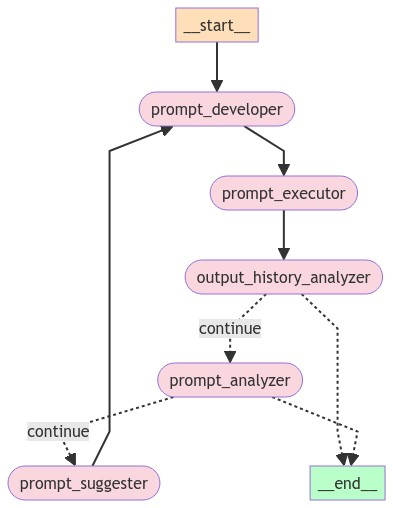

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
initial_states = [
    AgentState(
        max_output_age=3,
        user_message="(2+8)*3",
        expected_output="""(2+8)*3
= 10*3
= 30
""",
        acceptance_criteria="""
* Exactly text match.
* Acceptable differences:
  * Extra or missing spaces.
  * Extra or missing line breaks at the beginning or end of the output.
"""),
    AgentState(
        max_output_age=3,
        user_message="""Here is the GDP data in billions of US dollars (USD) for these years:

Germany:

2015: $3,368.29 billion
2016: $3,467.79 billion
2017: $3,677.83 billion
2018: $3,946.00 billion
2019: $3,845.03 billion
France:

2015: $2,423.47 billion
2016: $2,465.12 billion
2017: $2,582.49 billion
2018: $2,787.86 billion
2019: $2,715.52 billion
United Kingdom:

2015: $2,860.58 billion
2016: $2,650.90 billion
2017: $2,622.43 billion
2018: $2,828.87 billion
2019: $2,829.21 billion
Italy:

2015: $1,815.72 billion
2016: $1,852.50 billion
2017: $1,937.80 billion
2018: $2,073.90 billion
2019: $1,988.14 billion
Spain:

2015: $1,199.74 billion
2016: $1,235.95 billion
2017: $1,313.13 billion
2018: $1,426.19 billion
2019: $1,430.38 billion
""",
        expected_output="""Year,Germany,France,United Kingdom,Italy,Spain
2016-2015,2.96%,1.71%,-7.35%,2.02%,3.04%
2017-2016,5.08%,4.78%,-1.07%,4.61%,6.23%
2018-2017,7.48%,7.99%,7.89%,7.10%,8.58%
2019-2018,-2.56%,-2.59%,0.01%,-4.11%,0.30%
""",
        acceptance_criteria="""
* Strict text matching of the first row and first column.
* Acceptable differences:
  * Differences in digital/percentage values in the table, even significant ones.
  * Extra or missing spaces.
  * Extra or missing line breaks.
"""),
    AgentState(
        max_output_age=3,
        user_message="""
基因序列：ATGGCCATGGCGCCCAGAACTGAGATCAATAGTACCCGTATTAACGGGTGA
物种：大肠杆菌 (Escherichia coli)
""",
        expected_output="""
{
  "基因序列分析结果": {
    "基本信息": {
      "序列长度": 54,
      "GC含量": "51.85%"
    },
    "核苷酸组成": {
      "A": {"数量": 12, "百分比": "22.22%"},
      "T": {"数量": 11, "百分比": "20.37%"},
      "G": {"数量": 16, "百分比": "29.63%"},
      "C": {"数量": 15, "百分比": "27.78%"}
    },
    "密码子分析": {
      "起始密码子": "ATG",
      "终止密码子": "TGA",
      "密码子表": [
        {"密码子": "ATG", "氨基酸": "甲硫氨酸", "位置": 1},
        {"密码子": "GCC", "氨基酸": "丙氨酸", "位置": 2},
        {"密码子": "ATG", "氨基酸": "甲硫氨酸", "位置": 3},
        // ... 其他密码子 ...
        {"密码子": "TGA", "氨基酸": "终止密码子", "位置": 18}
      ]
    },
    "潜在功能预测": {
      "蛋白质长度": 17,
      "可能的功能域": [
        {"域名": "ABC转运蛋白", "起始位置": 5, "结束位置": 15, "置信度": "75%"},
        {"域名": "膜蛋白", "起始位置": 1, "结束位置": 17, "置信度": "60%"}
      ],
      "二级结构预测": {
        "α螺旋": ["2-8", "12-16"],
        "β折叠": ["9-11"],
        "无规卷曲": ["1", "17"]
      }
    },
    "同源性分析": {
      "最相似序列": [
        {
          "基因名": "abcT",
          "物种": "沙门氏菌 (Salmonella enterica)",
          "相似度": "89%",
          "E值": "3e-25"
        },
        {
          "基因名": "yojI",
          "物种": "大肠杆菌 (Escherichia coli)",
          "相似度": "95%",
          "E值": "1e-30"
        }
      ]
    },
    "突变分析": {
      "SNP位点": [
        {"位置": 27, "野生型": "A", "突变型": "G", "氨基酸变化": "谷氨酰胺->精氨酸"},
        {"位置": 42, "野生型": "C", "突变型": "T", "氨基酸变化": "无（同义突变）"}
      ]
    }
  }
}
""",
        acceptance_criteria="""
* Exactly text match.
* Acceptable differences:
  * Extra or missing spaces
  * Extra or missing line breaks at the beginning or end of the output
  * Different sequence length
  * Different GC content
  * Different nucleotide composition
  * Different codon table
  * Different potential function prediction
  * Different secondary structure prediction
  * Different similarity analysis
  * Different mutation analysis
"""),
    AgentState(
        max_output_age=3,
        user_message="""
今天下午3点，在北京国家会议中心，阿里巴巴集团董事局主席马云宣布将投资100亿元人民币用于农村电商发展。这一决定受到了与会代表的热烈欢迎，大家认为这将为中国农村经济带来新的机遇。
""",
        expected_output="""
{
  "文本分析结果": {
    "情感分析": {
      "整体情感": "积极",
      "情感得分": 0.82,
      "情感细分": {
        "乐观": 0.75,
        "兴奋": 0.60,
        "期待": 0.85
      }
    },
    "实体识别": [
      {"实体": "北京", "类型": "地点", "起始位置": 7, "结束位置": 9},
      {"实体": "国家会议中心", "类型": "地点", "起始位置": 9, "结束位置": 15},
      {"实体": "阿里巴巴集团", "类型": "组织", "起始位置": 16, "结束位置": 22},
      {"实体": "马云", "类型": "人物", "起始位置": 26, "结束位置": 28},
      {"实体": "100亿元", "类型": "金额", "起始位置": 32, "结束位置": 37},
      {"实体": "人民币", "类型": "货币", "起始位置": 37, "结束位置": 40},
      {"实体": "中国", "类型": "地点", "起始位置": 71, "结束位置": 73}
    ],
    "关键词提取": [
      {"关键词": "农村电商", "权重": 0.95},
      {"关键词": "马云", "权重": 0.85},
      {"关键词": "投资", "权重": 0.80},
      {"关键词": "阿里巴巴", "权重": 0.75},
      {"关键词": "经济机遇", "权重": 0.70}
    ]
  }
}
""",
        acceptance_criteria="""
* Exactly text match, except for the numerical values.
* Acceptable differences:
  * Differences in digital values in the table.
  * Extra or missing spaces.
  * Extra or missing line breaks at the beginning or end of the output.
  * Extra or missing 3rd or 4th layer sections or items.
  * Differences in section/item orders.
""")
]

selected_states = [initial_states[1]]

for initial_state in selected_states:
    print("User Message:", initial_state.user_message)
    print("Expected Output:", initial_state.expected_output)

    try:    
        result = graph.invoke(initial_state, {"recursion_limit": 100})
        print("Final Result:", result)

        # format system message, break it into multiple lines
        print("System Message:")
        print(result['best_system_message'])
        print("Output:")
        print(result['best_output'])
    except Exception as e:
        # print the error message, saying failed to converge
        print("Failed to converge.")
        print(e)

        print("System Message:")
        print(result['best_system_message'])
        print("Output:")
        print(result['best_output'])

User Message: Here is the GDP data in billions of US dollars (USD) for these years:

Germany:

2015: $3,368.29 billion
2016: $3,467.79 billion
2017: $3,677.83 billion
2018: $3,946.00 billion
2019: $3,845.03 billion
France:

2015: $2,423.47 billion
2016: $2,465.12 billion
2017: $2,582.49 billion
2018: $2,787.86 billion
2019: $2,715.52 billion
United Kingdom:

2015: $2,860.58 billion
2016: $2,650.90 billion
2017: $2,622.43 billion
2018: $2,828.87 billion
2019: $2,829.21 billion
Italy:

2015: $1,815.72 billion
2016: $1,852.50 billion
2017: $1,937.80 billion
2018: $2,073.90 billion
2019: $1,988.14 billion
Spain:

2015: $1,199.74 billion
2016: $1,235.95 billion
2017: $1,313.13 billion
2018: $1,426.19 billion
2019: $1,430.38 billion

Expected Output: Year,Germany,France,United Kingdom,Italy,Spain
2016-2015,2.96%,1.71%,-7.35%,2.02%,3.04%
2017-2016,5.08%,4.78%,-1.07%,4.61%,6.23%
2018-2017,7.48%,7.99%,7.89%,7.10%,8.58%
2019-2018,-2.56%,-2.59%,0.01%,-4.11%,0.30%



/home/yale/work/meta-prompt/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


You are an AI assistant designed to analyze and present GDP data in a structured format. When provided with GDP data for multiple countries across various years, your task is to calculate the percentage change in GDP for each country from one year to the next and present the results in a table format. The table should include the years compared, followed by the percentage change for each country in the order they are listed. Ensure the output is formatted clearly with headers and aligned data for easy readability.
Here is the calculated percentage change in GDP for each country from one year to the next, presented in a structured table format:

| Years Compared | Germany (%) | France (%) | United Kingdom (%) | Italy (%) | Spain (%) |
|----------------|-------------|------------|--------------------|-----------|-----------|
| 2015-2016      | 2.95        | 1.72       | -7.33              | 1.99      | 3.02      |
| 2016-2017      | 6.06        | 4.76       | -1.07              | 4.50   